# Model Analysis - Interactions

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/model_analysis_interactions'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################

In [5]:
sequences = FHS.get_sequences_df(only_tested=False)
pdb_interactions = FHS.get_1xpb_interactions()

In [6]:
#remove positions in which either position is not aligned in the model
pdb_interactions = pdb_interactions.dropna()

In [7]:
def get_interaction_df():
    mutated_model_positions = list(
        sequences[
            sequences.is_design==1
        ].model_mutations.explode().apply(
            lambda mut: int(mut[1:-1])
        ).unique()
    )

    interaction_df = pd.DataFrame()
    interaction_df['position'] = pd.concat([
        pdb_interactions['model_i'],
        pdb_interactions['model_j'],
    ])
    interaction_df['mutated'] = interaction_df.position.apply(
        lambda pos: True if pos in mutated_model_positions else False
    )
    interaction_df['interaction_count'] = interaction_df.groupby(
        'position'
    )['position'].transform('count')
    interaction_df = interaction_df.drop_duplicates().sort_values(
        by='position'
    )
    return interaction_df

## Plot Data

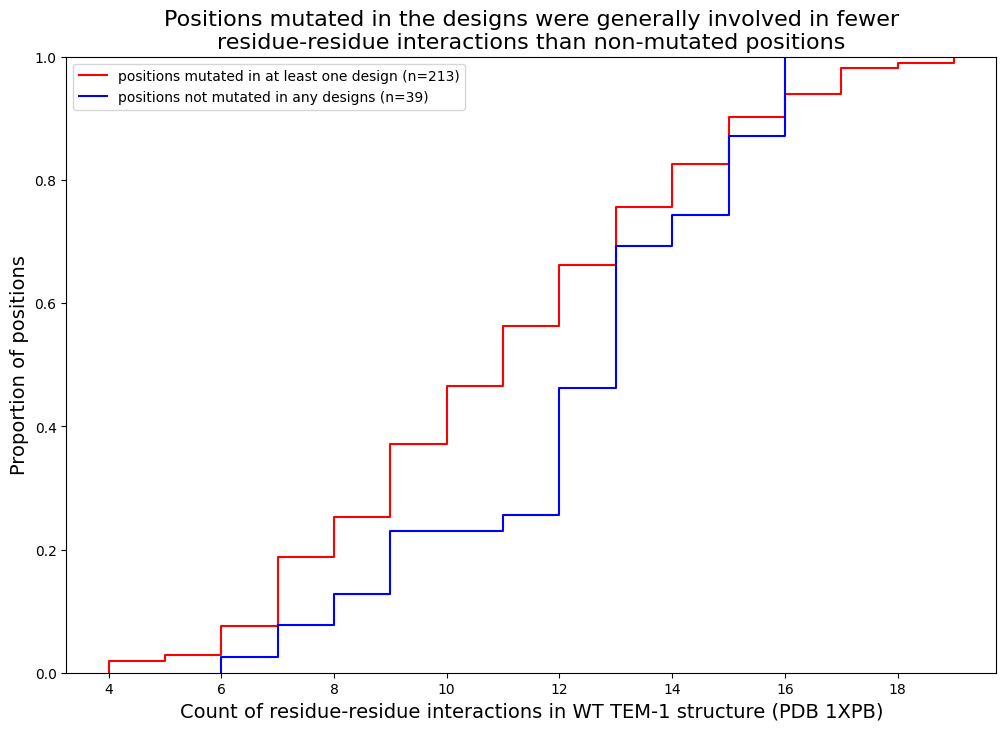

In [8]:
def plot_interaction_count_ecdf():
    interaction_df = get_interaction_df()
    
    #plot
    fig, ax = plt.subplots(1, 1)#, gridspec_kw={'height_ratios': [15, 1]}, sharex=True)
    fig.set_size_inches(12, 8)
    sns.ecdfplot(
        interaction_df[interaction_df.mutated==True], 
        x='interaction_count', color='red', ax=ax, 
        label='positions mutated in at least one design (n={0})'.format(len(
            interaction_df[interaction_df['mutated']]
        ))
    )
    sns.ecdfplot(
        interaction_df[interaction_df.mutated==False], 
        x='interaction_count', color='blue', ax=ax,
        label='positions not mutated in any designs (n={0})'.format(len(
            interaction_df[~interaction_df['mutated']]
        ))
    )

    #decorate
    ax.set_title(
        'Positions mutated in the designs were generally involved in fewer\n'+
        'residue-residue interactions than non-mutated positions',
        fontsize=16
    )
    ax.set_ylabel('Proportion of positions', fontsize=14)
    ax.set_xlabel(
        'Count of residue-residue interactions in WT TEM-1 structure (PDB 1XPB)', 
        fontsize=14
    )
    ax.legend(loc='upper left')
    fig.savefig(OUTPUT_DIR+'/model_analysis_interactions.pdf')

plot_interaction_count_ecdf()

In [9]:
def get_cdf_source_data():
    
    tmp_df = get_interaction_df()[[
        'position', 'mutated', 'interaction_count'
    ]].rename(columns={
        'position': 'Position (model numbering)',
        'mutated': 'Mutated in at Least One Design',
        'interaction_count': 'Interaction Count',
    })
    #sns.ecdfplot(
    #    data=tmp_df, 
    #    x='Interaction Count', 
    #    hue='Mutated in at Least One Design',
    #)
    return tmp_df
    
get_cdf_source_data().to_csv(
    OUTPUT_DIR+'/model_analysis_interactions.tab', 
    sep ='\t', 
    index=False
)